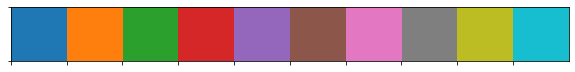

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.sparse import linalg as lg
from utils import ed
from utils import tfim
from utils import misc
from utils import calc

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

data_dir = "/home/stavros/DATA/ClockV3"
cp = sns.color_palette()
sns.palplot(cp)
plt.show()

In [4]:
n_sites = 6
time_steps = 100
h_ev = 0.5
t_grid = np.linspace(0, 2, time_steps + 1)
dt = t_grid[1] - t_grid[0]

ham = tfim.tfim_hamiltonian(n_sites, h=h_ev)
clock = ed.construct_sparse_clock(ham, dt, time_steps)

In [5]:
clock.shape

(6464, 6464)

In [ ]:
clock_energies = lg.eigsh(clock, k=3, which="SM", return_eigenvectors=False)

Calculate overlaps between exactly diagonalizing the Clock (with penalty) and the exact evolution for various $T$s

In [61]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

T_list = np.arange(20, 220, 20)
t_final = 3.0

ham = tfim.tfim_hamiltonian(n_sites, h=h_ev)
pauli = misc.Pauli()

get_norm = lambda state: (np.abs(state)**2).sum(axis=1)
get_clock_energy = lambda state, clock: (state.ravel().conj().dot(clock.toarray().dot(state.ravel())) 
                                         / (np.abs(state)**2).sum())
get_sigma_x = lambda state: calc.ev_local(state, pauli.X)


overlaps = {"composite": [], "avg": [], "time": []}
metrics = {"clock/norm": [], "clock/sigma_x": [], "clock/clock_energy": [],
           "exact/norm": [], "exact/sigma_x": [], "exact/clock_energy": []}
for time_steps in T_list:
    t = np.linspace(0.0, t_final, time_steps + 1)
    dt = t[1] - t[0]
        
    # Calculate exact evolution
    exact_state, obs = tfim.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
        
    # Calculate clock evolution
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    # Solve system instead of diagonalizing because diagonalization is VERY SLOW!
    clock_state = ed.solve_evolution_system(clock, psi0=exact_state[0], solver=lg.gmres)
    print("T = {}\n".format(time_steps))
    
    # Calculate overlaps
    overlaps["time"].append(calc.time_overlap(exact_state, clock_state))
    overlaps["avg"].append(overlaps["time"][-1].mean())
    overlaps["composite"].append(calc.overlap(exact_state, clock_state))
    
    # Calculate metrics
    for key, state in zip(["exact", "clock"], [exact_state, clock_state]):
        metrics["{}/norm".format(key)].append(get_norm(state))
        metrics["{}/clock_energy".format(key)].append(get_clock_energy(state, clock))
        metrics["{}/sigma_x".format(key)].append(get_sigma_x(state))
        
        
# Save so that you don't have to run the above all the time.
import h5py
file = h5py.File("ed_N{}tf{}.h5".format(n_sites, t_final), "w")
file["T_list"] = T_list

file["overlaps/composite"] = overlaps["composite"]
file["overlaps/avg"] = overlaps["avg"]
file["metrics/clock/clock_energy"] = metrics["clock/clock_energy"]
file["metrics/exact/clock_energy"] = metrics["exact/clock_energy"]

for i in range(len(T_list)):
    file["overlaps/time/{}".format(i)] = overlaps["time"][i]
    file["metrics/clock/norm/{}".format(i)] = metrics["clock/norm"][i]
    file["metrics/exact/norm/{}".format(i)] = metrics["exact/norm"][i]
    file["metrics/clock/sigma_x/{}".format(i)] = metrics["clock/sigma_x"][i]
    file["metrics/exact/sigma_x/{}".format(i)] = metrics["exact/sigma_x"][i]

file.close()

Convergence status: 0
T = 20

Convergence status: 0
T = 40

Convergence status: 0
T = 60



KeyboardInterrupt: 

Composite and averaged overlap as a function of time steps

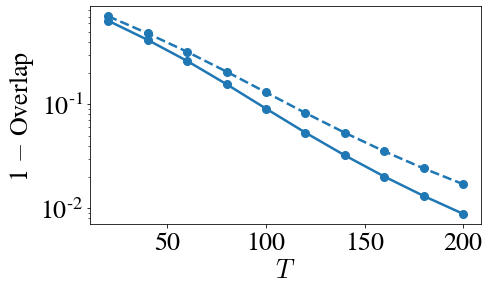

In [112]:
file = h5py.File("{}/ed/ed_N{}tf{}.h5".format(data_dir, n_sites, t_final), "r")

plt.figure(figsize=(7, 4))
plt.semilogy(T_list, 1 - file["overlaps/avg"][()], marker="o", linewidth=2.5, markersize=8, color=cp[0])
plt.semilogy(T_list, 1 - file["overlaps/composite"][()], marker="o", linewidth=2.5, markersize=8, 
             color=cp[0], linestyle="--")
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.show()

file.close()

Clock energy as a function of time steps. Note that the exact state's clock energy is lower than the one we find by solving the system, because solving the system is not equivalent to diagonalizing the Clock (remember that solving the system assumes that the Clock has eigenvalue zero that is not true!). If we diagonalize the Clock normally (SLOW) we will find an even smaller Clock energy here.

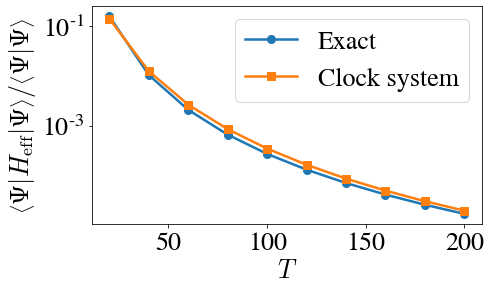

In [126]:
file = h5py.File("{}/ed/ed_N{}tf{}.h5".format(data_dir, n_sites, t_final), "r")

plt.figure(figsize=(7, 4))
plt.semilogy(T_list, file["metrics/exact/clock_energy"][()], marker="o", linewidth=2.5, markersize=8, 
             color=cp[0], label="Exact")
plt.semilogy(T_list, file["metrics/clock/clock_energy"][()], marker="s", linewidth=2.5, markersize=8, 
             color=cp[1], label="Clock system")
plt.xlabel("$T$")
plt.ylabel(r"$\left \langle \Psi | H_\mathrm{eff} | \Psi \right \rangle / \left \langle \Psi | \Psi \right \rangle$")
plt.legend()
plt.show()

file.close()

Fidelity (overlap) as a function of time

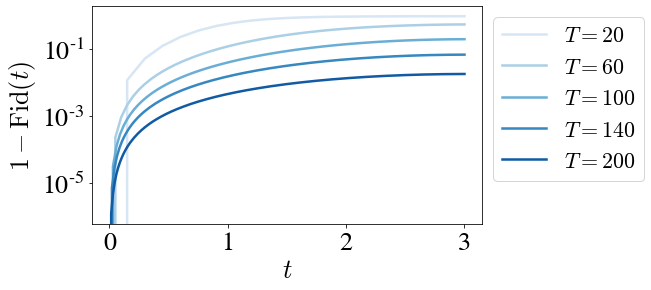

In [105]:
n_sites = 6
t_final = 3.0
file = h5py.File("{}/ed/ed_N{}tf{}.h5".format(data_dir, n_sites, t_final), "r")
cseq = sns.color_palette("Blues", 5)

plt.figure(figsize=(7, 4))
for i, Ti in enumerate([0, 2, 4, 6, 9]):
    time_steps = file["T_list"][Ti]
    t = np.linspace(0.0, t_final, time_steps + 1)
    plt.semilogy(t, 1 - file["overlaps/time/{}".format(Ti)][()], linewidth=2.5, color=cseq[i], 
                 label="$T={}$".format(time_steps))
plt.xlabel("$t$")
plt.ylabel(r"$1 - \mathrm{Fid}(t)$")
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=22)
plt.show()
#plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

file.close()

Norm as a function of time

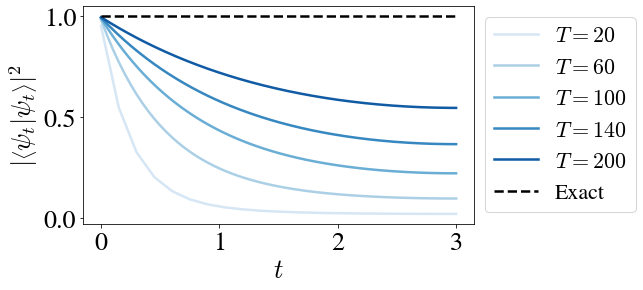

In [104]:
n_sites = 6
t_final = 3.0
file = h5py.File("{}/ed/ed_N{}tf{}.h5".format(data_dir, n_sites, t_final), "r")
cseq = sns.color_palette("Blues", 5)

plt.figure(figsize=(7, 4))
for i, Ti in enumerate([0, 2, 4, 6, 9]):
    time_steps = file["T_list"][Ti]
    t = np.linspace(0.0, t_final, time_steps + 1)
    plt.plot(t, (time_steps) * file["metrics/clock/norm/{}".format(Ti)][()], 
             linewidth=2.5, color=cseq[i], label="$T={}$".format(time_steps))
plt.plot(t, file["metrics/exact/norm/{}".format(Ti)][()], linestyle="--",
         linewidth=2.5, color="black", label="Exact")
plt.xlabel("$t$")
plt.ylabel(r"$|\left \langle \psi _t | \psi _t\right \rangle |^2$")
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=22)
plt.show()
#plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

file.close()

$\sigma ^x$ as a function of time without normalizing at each time step

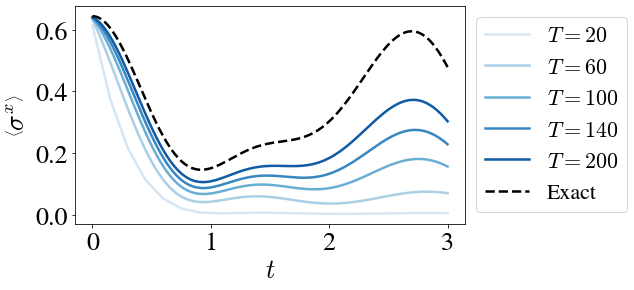

In [103]:
n_sites = 6
t_final = 3.0
file = h5py.File("{}/ed/ed_N{}tf{}.h5".format(data_dir, n_sites, t_final), "r")
cseq = sns.color_palette("Blues", 5)

plt.figure(figsize=(7, 4))
for i, Ti in enumerate([0, 2, 4, 6, 9]):
    time_steps = file["T_list"][Ti]
    t = np.linspace(0.0, t_final, time_steps + 1)
    plt.plot(t, (time_steps) * file["metrics/clock/sigma_x/{}".format(Ti)][()], 
             linewidth=2.5, color=cseq[i], label="$T={}$".format(time_steps))
plt.plot(t, file["metrics/exact/sigma_x/{}".format(Ti)][()], linestyle="--",
         linewidth=2.5, color="black", label="Exact")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma ^x\right \rangle $")
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=22)
plt.show()
#plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

file.close()

$\sigma ^x$ as a function of time after normalizing at each time step

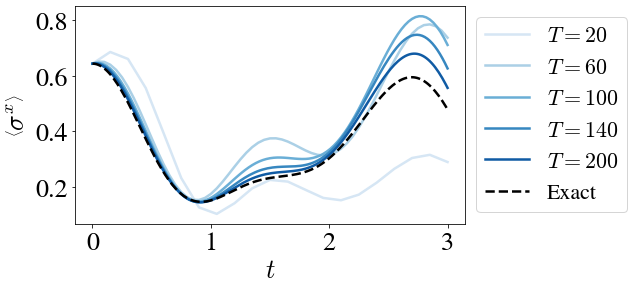

In [107]:
n_sites = 6
t_final = 3.0
file = h5py.File("{}/ed/ed_N{}tf{}.h5".format(data_dir, n_sites, t_final), "r")
cseq = sns.color_palette("Blues", 5)

plt.figure(figsize=(7, 4))
for i, Ti in enumerate([0, 2, 4, 6, 9]):
    time_steps = file["T_list"][Ti]
    t = np.linspace(0.0, t_final, time_steps + 1)
    sigma_x = file["metrics/clock/sigma_x/{}".format(Ti)][()]
    norm = file["metrics/clock/norm/{}".format(Ti)][()]
    plt.plot(t, sigma_x / norm, linewidth=2.5, color=cseq[i], 
             label="$T={}$".format(time_steps))
plt.plot(t, file["metrics/exact/sigma_x/{}".format(Ti)][()], linestyle="--",
         linewidth=2.5, color="black", label="Exact")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma ^x\right \rangle $")
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=22)
plt.show()
#plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

file.close()

All together (for notes)

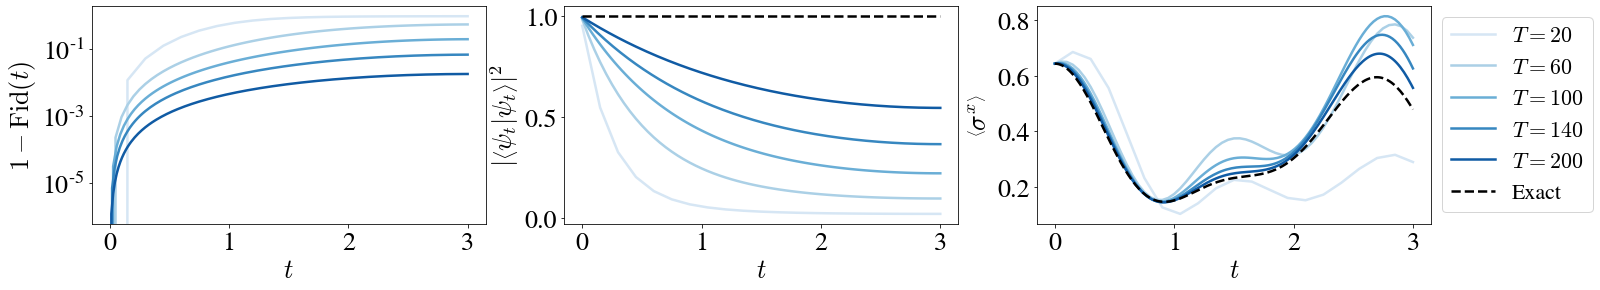

In [118]:
n_sites = 6
t_final = 3.0
file = h5py.File("{}/ed/ed_N{}tf{}.h5".format(data_dir, n_sites, t_final), "r")
cseq = sns.color_palette("Blues", 5)

plt.figure(figsize=(24, 4))

plt.subplot(131)
for i, Ti in enumerate([0, 2, 4, 6, 9]):
    time_steps = file["T_list"][Ti]
    t = np.linspace(0.0, t_final, time_steps + 1)
    plt.semilogy(t, 1 - file["overlaps/time/{}".format(Ti)][()], linewidth=2.5, color=cseq[i], 
                 label="$T={}$".format(time_steps))
plt.xlabel("$t$")
plt.ylabel(r"$1 - \mathrm{Fid}(t)$")

plt.subplot(132)
for i, Ti in enumerate([0, 2, 4, 6, 9]):
    time_steps = file["T_list"][Ti]
    t = np.linspace(0.0, t_final, time_steps + 1)
    plt.plot(t, (time_steps) * file["metrics/clock/norm/{}".format(Ti)][()], 
             linewidth=2.5, color=cseq[i], label="$T={}$".format(time_steps))
plt.plot(t, file["metrics/exact/norm/{}".format(Ti)][()], linestyle="--",
         linewidth=2.5, color="black", label="Exact")
plt.xlabel("$t$")
plt.ylabel(r"$|\left \langle \psi _t | \psi _t\right \rangle |^2$")

plt.subplot(133)
for i, Ti in enumerate([0, 2, 4, 6, 9]):
    time_steps = file["T_list"][Ti]
    t = np.linspace(0.0, t_final, time_steps + 1)
    sigma_x = file["metrics/clock/sigma_x/{}".format(Ti)][()]
    norm = file["metrics/clock/norm/{}".format(Ti)][()]
    plt.plot(t, sigma_x / norm, linewidth=2.5, color=cseq[i], 
             label="$T={}$".format(time_steps))
plt.plot(t, file["metrics/exact/sigma_x/{}".format(Ti)][()], linestyle="--",
         linewidth=2.5, color="black", label="Exact")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma ^x\right \rangle $")
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=22)

#plt.show()
plt.savefig("ed_plots.pdf", bbox_inches='tight')

file.close()